In [1]:
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import random
import math
import string
import codecs
import matplotlib.pyplot as plt
import numpy as np
import mxnet as mx

In [2]:
class RandomChar():
    """用于随机生成汉字"""
    @staticmethod
    def Unicode():
        val = random.randint(0x4E00, 0x9FBF)
        return chr(val)

    @staticmethod
    def GB2312():
        # head = random.randint(0xB0, 0xCF)
        # body = random.randint(0xA, 0xF)
        # tail = random.randint(0, 0xF)
        # val = (head &lt; &lt; 8) | (body & lt; & lt; 4) | tail
        head = random.randint(0xB0, 0xB2)
        body = random.randint(0xA1, 0xFE)
        val = (head << 8) | body
        str = "%x" % val
        str = codecs.decode(str, 'hex')
        str = str.decode('gb2312')
        # return str.decode('hex').decode('gb2312')
        return str, val


s = []
for head in range(0xB0, 0xB3):
    for body in range(0xA1, 0xFE + 1):
        val = (head << 8) | body
        s.append(val)

a = s.copy()
a = ['%x' % i for i in a]
a = [codecs.decode(i, 'hex').decode('gb2312') for i in a]

class ImageChar():

    def __init__(self, fontColor=(255, 255, 255),
                 size=(100, 20),
                 fontPath='ukai.ttc',
                 bgColor=(0, 0, 0),
                 fontSize=20):
        self.size = size
        self.fontPath = fontPath
        self.bgColor = bgColor
        self.fontSize = fontSize
        self.fontColor = fontColor
        self.font = ImageFont.truetype(self.fontPath, self.fontSize)
        self.image = Image.new('RGB', size, bgColor)

    # def rotate(self):
    #     self.image = self.image.rotate(10, expand=0)

    def drawText(self, pos, txt, fill):
        draw = ImageDraw.Draw(self.image)
        draw.text(pos, txt, font=self.font, fill=fill)
        del draw

    def drawTextV2(self, pos, txt, fill):
        image = Image.new('RGB', (20, 20), (0, 0, 0))
        draw = ImageDraw.Draw(image)
        draw.text((0, -3), txt, font=self.font, fill=fill)
        w = image.rotate(random.randint(-10, 10), expand=1)
        self.image.paste(w, box=pos)
        del draw

    # def randRGB(self):
    #     return (random.randint(0, 255),
    #             random.randint(0, 255),
    #             random.randint(0, 255))

    def randPoint(self, num):
        (width, height) = self.size
        draw = ImageDraw.Draw(self.image)
        for i in range(0, num):
            draw.point([random.randint(0, width),
                        random.randint(0, height)], (255, 255, 255))
        # return (random.randint(0, width), random.randint(0, height)
        del draw

    # def randLine(self, num):
    #     draw = ImageDraw.Draw(self.image)
    #     for i in range(0, num):
    #         draw.line([self.randPoint(), self.randPoint()], self.randRGB())
    #     del draw

    def randChinese(self, num):
        gap = 5
        start = 0
        label = []
        while len(label) < num:
            try:
                char, val = RandomChar().GB2312()
            except UnicodeDecodeError:
                # print(len(label))
                continue
            x = start + self.fontSize * \
                len(label) + random.randint(0, gap) + gap * len(label)
            self.drawTextV2((x, random.randint(-3, 2)),
                            char, (255, 255, 255))
            # self.image.rotate(180)
            # self.rotate()
            label.append(s.index(val))
        self.randPoint(18)
        return label

    def save(self, path):
        self.image.save(path)

In [3]:
class OCRBatch(object):

    def __init__(self, data_names, data, label_names, label):
        self.data = data
        self.label = label
        self.data_names = data_names
        self.label_names = label_names

    @property
    def provide_data(self):
        return [(n, x.shape) for n, x in zip(self.data_names, self.data)]

    @property
    def provide_label(self):
        return [(n, x.shape) for n, x in zip(self.label_names, self.label)]

    def all_data(self):
        return self.data


class OCRIter(mx.io.DataIter):

    def __init__(self, count, batch_size, num_label):
        super(OCRIter, self).__init__()
        # self.ic = ImageChar()

        self.batch_size = batch_size
        self.count = count
        self.num_label = num_label
        self.provide_data = [('data', (batch_size, 1, 100, 20))]
        self.provide_label = [('softmax_label', (self.batch_size, num_label))]

    def __iter__(self):
        for k in range(int(self.count / self.batch_size)):
            data = []
            label = []
            for i in range(self.batch_size):
                ic = ImageChar(fontPath='/home/plkj/ukai.ttc')
                # num = self.ic.randChinese(self.num_label)
                num = ic.randChinese(self.num_label)
                # name = ''
                # for index in num:
                #     name += a[index]
                # self.ic.save(str(k) + str(i) + '.jpg')
                # tmp = np.array(self.ic.image.convert("L"))
                # ic.save(str(k) + str(i) + str(name) + '.jpg')
                tmp = np.array(ic.image.convert("L"))
                tmp = 255 - tmp
                tmp = tmp.reshape(1, 100, 20)
                # print(tmp.shape)
                data.append(tmp)
                label.append(np.array(num))
            data_all = [mx.nd.array(data)]
            label_all = [mx.nd.array(label)]
            data_names = ['data']
            label_names = ['softmax_label']

            data_batch = OCRBatch(data_names, data_all, label_names, label_all)
            yield data_batch

    def reset(self):
        pass

In [4]:
def get_ocrnet():
    data = mx.sym.Variable('data')
    label = mx.sym.Variable('softmax_label')
    conv1 = mx.sym.Convolution(data=data, kernel=(7, 7), num_filter=64, stride=(2, 2))
    relu1 = mx.sym.Activation(data=conv1, act_type="relu")
    pool1 = mx.sym.Pooling(
        data=relu1, pool_type="max", kernel=(3, 3), stride=(2, 2))

    conv2 = mx.sym.Convolution(data=pool1, kernel=(1, 1), num_filter=64, stride=(1, 1))
    relu2 = mx.sym.Activation(data=conv2, act_type="relu")
    conv3 = mx.sym.Convolution(data=relu2, kernel=(3, 3), num_filter=64, stride=(1, 1))
    relu3 = mx.sym.Activation(data=conv3, act_type="relu")
    pool3 = mx.sym.Pooling(
        data=relu3, pool_type="max", kernel=(3, 3), stride=(2, 2))
    
    conv4_1 = mx.sym.Convolution(data=pool3, kernel=(1, 1), num_filter=64, stride=(1, 1))
    relu4_1 = mx.sym.Activation(data=conv4_1, act_type="relu")
    conv4_2 = mx.sym.Convolution(data=pool3, kernel=(1, 1), num_filter=64, stride=(1, 1))
    relu4_2 = mx.sym.Activation(data=conv4_2, act_type="relu")
    pool4 = mx.sym.Pooling(
        data=pool3, pool_type="max", kernel=(3, 3), stride=(1, 1))
    conv5_1 = mx.sym.Convolution(data=pool3, kernel=(1, 1), num_filter=64, stride=(1, 1))
    relu5_1 = mx.sym.Activation(data=conv5_1, act_type="relu")
    conv5_2 = mx.sym.Convolution(data=relu4_1, kernel=(3, 3), num_filter=64, stride=(1, 1))
    relu5_2 = mx.sym.Activation(data=conv5_2, act_type="relu")
    conv5_3 = mx.sym.Convolution(data=relu4_2, kernel=(5, 5), num_filter=64, stride=(1, 1))
    relu5_3 = mx.sym.Activation(data=conv5_3, act_type="relu")
    conv5_4 = mx.sym.Convolution(data=pool4, kernel=(1, 1), num_filter=64, stride=(1, 1))
    relu5_4 = mx.sym.Activation(data=conv5_4, act_type="relu")
    relu5 = mx.sym.Concat(*[relu5_1, relu5_2, relu5_3, relu5_4], dim=0)
    pool5 = mx.sym.Pooling(
        data=relu5, pool_type="avg", kernel=(5, 5), stride=(3, 3))
#     relu5 = mx.sym.Activation(data=pool5, act_type='relu')

    flatten = mx.sym.Flatten(data=pool5)
    fc1 = mx.sym.FullyConnected(data=flatten, num_hidden=4096)
    fc2 = mx.sym.FullyConnected(data=fc1, num_hidden=4096)
    fc31 = mx.sym.FullyConnected(data=fc2, num_hidden=282)
    fc32 = mx.sym.FullyConnected(data=fc2, num_hidden=282)
    fc33 = mx.sym.FullyConnected(data=fc2, num_hidden=282)
    fc3 = mx.sym.Concat(*[fc31, fc32, fc33], dim=0)
    label = mx.sym.transpose(data=label)
    label = mx.sym.Reshape(data=label, target_shape=(0, ))
    return mx.sym.SoftmaxOutput(data=fc3, label=label, name="softmax")

In [5]:
def ConvFactory(data, num_filter, kernel, stride=(1,1), pad=(0, 0), name=None, suffix=''):
    conv = mx.symbol.Convolution(data=data, num_filter=num_filter, kernel=kernel, stride=stride, pad=pad, name='conv_%s%s' %(name, suffix))
    act = mx.symbol.Activation(data=conv, act_type='relu', name='relu_%s%s' %(name, suffix))
    return act

def InceptionFactory(data, num_1x1, num_3x3red, num_3x3, num_d5x5red, num_d5x5, pool, proj, name):
    # 1x1
    c1x1 = ConvFactory(data=data, num_filter=num_1x1, kernel=(1, 1), name=('%s_1x1' % name))
    # 3x3 reduce + 3x3
    c3x3r = ConvFactory(data=data, num_filter=num_3x3red, kernel=(1, 1), name=('%s_3x3' % name), suffix='_reduce')
    c3x3 = ConvFactory(data=c3x3r, num_filter=num_3x3, kernel=(3, 3), pad=(1, 1), name=('%s_3x3' % name))
    # double 3x3 reduce + double 3x3
    cd5x5r = ConvFactory(data=data, num_filter=num_d5x5red, kernel=(1, 1), name=('%s_5x5' % name), suffix='_reduce')
    cd5x5 = ConvFactory(data=cd5x5r, num_filter=num_d5x5, kernel=(5, 5), pad=(2, 2), name=('%s_5x5' % name))
    # pool + proj
    pooling = mx.symbol.Pooling(data=data, kernel=(3, 3), stride=(1, 1), pad=(1, 1), pool_type=pool, name=('%s_pool_%s_pool' % (pool, name)))
    cproj = ConvFactory(data=pooling, num_filter=proj, kernel=(1, 1), name=('%s_proj' %  name))
    # concat
    concat = mx.symbol.Concat(*[c1x1, c3x3, cd5x5, cproj], name='ch_concat_%s_chconcat' % name)
    return concat

def get_symbol():
    data = mx.sym.Variable("data")
    label = mx.sym.Variable('softmax_label')
    conv1 = ConvFactory(data, 64, kernel=(7, 7), stride=(2,2), pad=(3, 3), name="conv1")
    pool1 = mx.sym.Pooling(conv1, kernel=(3, 3), stride=(2, 2), pool_type="max")
    conv2 = ConvFactory(pool1, 64, kernel=(1, 1), stride=(1,1), name="conv2")
    conv3 = ConvFactory(conv2, 192, kernel=(3, 3), stride=(1, 1), pad=(1,1), name="conv3")
    pool3 = mx.sym.Pooling(conv3, kernel=(3, 3), stride=(2, 2), pool_type="max")

    in3a = InceptionFactory(pool3, 64, 96, 128, 16, 32, "max", 32, name="in3a")
    pool2 = mx.sym.Pooling(in3a, kernel=(7, 7), stride=(1,1), pool_type="avg")
    flatten = mx.sym.Flatten(data=pool2)
    fc1 = mx.sym.FullyConnected(data=flatten, num_hidden=4096)
    fc21 = mx.sym.FullyConnected(data=fc1, num_hidden=282)
    fc22 = mx.sym.FullyConnected(data=fc1, num_hidden=282)
    fc23 = mx.sym.FullyConnected(data=fc1, num_hidden=282)
    fc2 = mx.sym.Concat(*[fc21, fc22, fc23], dim=0)
    label = mx.sym.transpose(data=label)
    label = mx.sym.Reshape(data=label, target_shape=(0, ))
    return mx.sym.SoftmaxOutput(data=fc2, label=label, name="softmax")

In [6]:
def Accuracy(label, pred):
    label = label.T.reshape((-1, ))
    hit = 0
    total = 0
    # print(pred)
    # print(pred.shape)
    for i in range(int(pred.shape[0] / 3)):
        ok = True
        predict = []
        true = []
        for j in range(3):
            k = i * 3 + j
            # print(k)
            predict.append(a[np.argmax(pred[k])])
            true.append(a[int(label[k])])
            if np.argmax(pred[k]) != int(label[k]):
                ok = False
                break
        if ok:
            hit += 1
        total += 1
    return hit / total

In [8]:
mx.viz.plot_network(symbol=get_symbol(), shape=shape)

infer_shape error. Arguments:
  softmax_label: (50, 3)
  data: (50, 1, 100, 20)


MXNetError: Error in operator pooling2: [15:56:43] src/operator/./pooling-inl.h:199: Check failed: param_.kernel[1] <= dshape[3] + 2 * param_.pad[1] kernel size (7) exceeds input (1 padded to 1)

Stack trace returned 10 entries:
[bt] (0) /usr/local/lib/python3.5/dist-packages/mxnet/libmxnet.so(+0x184dfc) [0x7feb07653dfc]
[bt] (1) /usr/local/lib/python3.5/dist-packages/mxnet/libmxnet.so(+0xe025c0) [0x7feb082d15c0]
[bt] (2) /usr/local/lib/python3.5/dist-packages/mxnet/libmxnet.so(+0xc59198) [0x7feb08128198]
[bt] (3) /usr/local/lib/python3.5/dist-packages/mxnet/libmxnet.so(+0x25af6cd) [0x7feb09a7e6cd]
[bt] (4) /usr/local/lib/python3.5/dist-packages/mxnet/libmxnet.so(+0x25b0fc2) [0x7feb09a7ffc2]
[bt] (5) /usr/local/lib/python3.5/dist-packages/mxnet/libmxnet.so(+0x259b768) [0x7feb09a6a768]
[bt] (6) /usr/local/lib/python3.5/dist-packages/mxnet/libmxnet.so(+0xb0ab0e) [0x7feb07fd9b0e]
[bt] (7) /usr/local/lib/python3.5/dist-packages/mxnet/libmxnet.so(+0xb0d940) [0x7feb07fdc940]
[bt] (8) /usr/local/lib/python3.5/dist-packages/mxnet/libmxnet.so(MXSymbolInferShape+0x329) [0x7feb07fd47d9]
[bt] (9) /usr/lib/python3.5/lib-dynload/_ctypes.cpython-35m-x86_64-linux-gnu.so(ffi_call_unix64+0x4c) [0x7feb5f0d8e20]


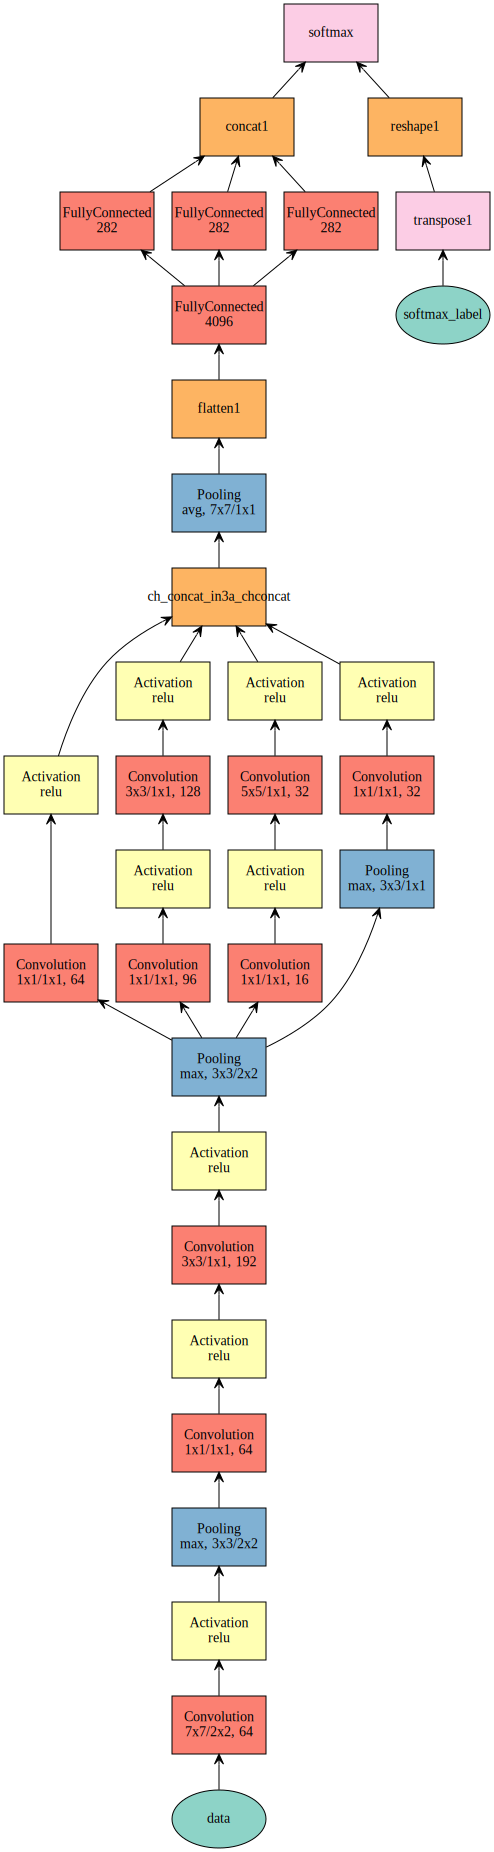

In [9]:
mx.viz.plot_network(symbol=get_symbol())

In [7]:
batch_size = 50
data_train = OCRIter(100000, batch_size, 3)
data_test = OCRIter(10000, batch_size, 3)
shape = {"data": (batch_size, 1, 100, 20), "softmax_label": (batch_size, 3)}
# mx.viz.plot_network(symbol=get_ocrnet(), shape=shape)

In [ ]:
import logging
logging.getLogger().setLevel(logging.DEBUG)
model = mx.mod.Module(symbol=get_ocrnet(), context=mx.gpu(),
                      data_names=['data'], label_names=['softmax_label'])

model.fit(train_data=data_train, eval_data=data_test, optimizer='sgd',
          optimizer_params={'learning_rate': 0.001},
          eval_metric=Accuracy, num_epoch=200,
          batch_end_callback=mx.callback.Speedometer(batch_size, 50))